# GoodReads Data Analysis

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore") #comment this out if there are unexpected errors below

In [177]:
raw = pd.read_csv('ReadingHistory.csv')

## Cleaning & Tidying

Checklist
 - Drop duplicates
 - Drop unread books
 - Convert "My Rating" column into integer on a scale of 1 to 5
 - Convert all Date strings to DateTime values
 
Note on Dates in Pandas (from StackOverflow):

Since pandas represents timestamps in nanosecond resolution, the timespan that can be represented using a 64-bit integer is limited to approximately 584 years. The earliest time stamp that can be represented as of this writing is 1677. So, writings by Plato or Shakespear, to name a few, will be eliminated from the dataset. 

In [178]:
raw = raw.drop_duplicats(subset=['Title'], keep=False)
all_books = raw['Title'].count()
books_read = raw.dropna(subset=['My Rating'])
books_read_count = books_read['Title'].count()
books_unread = raw[raw['Read Count'] == 0]
books_unread_count = books_unread['Title'].count()

In [179]:
#Translate "My Rating" column into integers
def label_rating_integer (row):
   if row['My Rating'] == 'did not like it' :
      return 1
   if row['My Rating'] == 'it was ok' :
      return 2
   if row['My Rating'] == 'liked it' :
      return 3
   if row['My Rating']  == 'really liked it' :
      return 4
   if row['My Rating'] == 'it was amazing' :
      return 5
    
books_read['My Rating (int)'] = books_read.apply(lambda row: label_rating_integer(row), axis=1)

In [180]:
def guess_date(string):
    for format_style in ['%b %d, %Y', '%b %d %Y', '%b %Y', '%Y']:
        #Cells with only a year will autofill to the the first day of the first month of that year
        #Cells with only a month and year will autofill to the first day of that month
        #Cells with "Unknown" will autofill to "None"
        try:
            return datetime.datetime.strptime(string, format_style).date()
        except ValueError:
            continue
#    raise ValueError(string)

In [181]:
books_read['Publish Date'] = books_read['Publish Date'].apply(lambda x: guess_date(x))
books_read['Publish Date Edition'] = books_read['Publish Date Edition'].apply(lambda x: guess_date(x))
books_read['Date Started'] = books_read['Date Started'].apply(lambda x: guess_date(x))
books_read['Date Read'] = books_read['Date Read'].apply(lambda x: guess_date(x))
books_read['Date Added'] = books_read['Date Added'].apply(lambda x: guess_date(x))

In [182]:
books_read['Publish Date'] = pd.to_datetime(books_read['Publish Date'], errors='coerce')
books_read['Publish Date Edition'] = pd.to_datetime(books_read['Publish Date Edition'], errors='coerce')
books_read['Date Started'] = pd.to_datetime(books_read['Date Started'], errors='coerce')
books_read['Date Read'] = pd.to_datetime(books_read['Date Read'], errors='coerce')
books_read['Date Added'] = pd.to_datetime(books_read['Date Added'], errors='coerce')

In [183]:
books_read['Reading Time (Days)'] = books_read['Date Read'] - books_read['Date Started']
books_read['Reading Time (Days)'] = books_read['Reading Time (Days)'].dt.days

In [184]:
print("There are {} books in your GoodReads account".format(all_books))
print("There are {} read books".format(books_read_count))
print("There are {} unread books".format(books_unread_count))

print('Most recent addition:')
print('')
# print(books_read['Date Read'].max())
print(books_read.loc[books_read['Date Read'].idxmax()])

There are 708 books in your GoodReads account
There are 584 read books
There are 86 unread books
Most recent addition:

Title                   What Belongs to You
Author                     Greenwell, Garth
ISBN                             0374288224
IBSN13                      9780374288228.0
Number of Pages                       195.0
Average Rating                         3.77
Number of Ratings                     10877
Publish Date            2016-01-19 00:00:00
Publish Date Edition    2016-01-19 00:00:00
My Rating                    it was amazing
Shelves                        1 of 5 stars
Read Count                                1
Date Started            2021-07-05 00:00:00
Date Read               2021-07-07 00:00:00
Date Added              2021-06-24 00:00:00
My Rating (int)                           5
Reading Time (Days)                     2.0
Name: 4, dtype: object


In [185]:
books_read.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 707
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Title                 584 non-null    object        
 1   Author                584 non-null    object        
 2   ISBN                  528 non-null    object        
 3   IBSN13                531 non-null    float64       
 4   Number of Pages       576 non-null    float64       
 5   Average Rating        584 non-null    float64       
 6   Number of Ratings     584 non-null    int64         
 7   Publish Date          565 non-null    datetime64[ns]
 8   Publish Date Edition  580 non-null    datetime64[ns]
 9   My Rating             584 non-null    object        
 10  Shelves               584 non-null    object        
 11  Read Count            584 non-null    int64         
 12  Date Started          98 non-null     datetime64[ns]
 13  Date Read           

In [186]:
books_read.isnull().sum()

Title                     0
Author                    0
ISBN                     56
IBSN13                   53
Number of Pages           8
Average Rating            0
Number of Ratings         0
Publish Date             19
Publish Date Edition      4
My Rating                 0
Shelves                   0
Read Count                0
Date Started            486
Date Read               127
Date Added                0
My Rating (int)           0
Reading Time (Days)     486
dtype: int64

## Page Analysis

In [187]:
pages = raw['Number of Pages']
no_pages = pages.isnull().sum()
pages = pages.dropna()
books_with_page_counts = pages.count()

print('Books without page counts listed on Goodreads: {}'.format(no_pages))
print('Books that can be analyzed: {}'.format(books_with_page_counts))

There are 9 books without page counts listed on Goodreads
Only 699 books can be analyzed


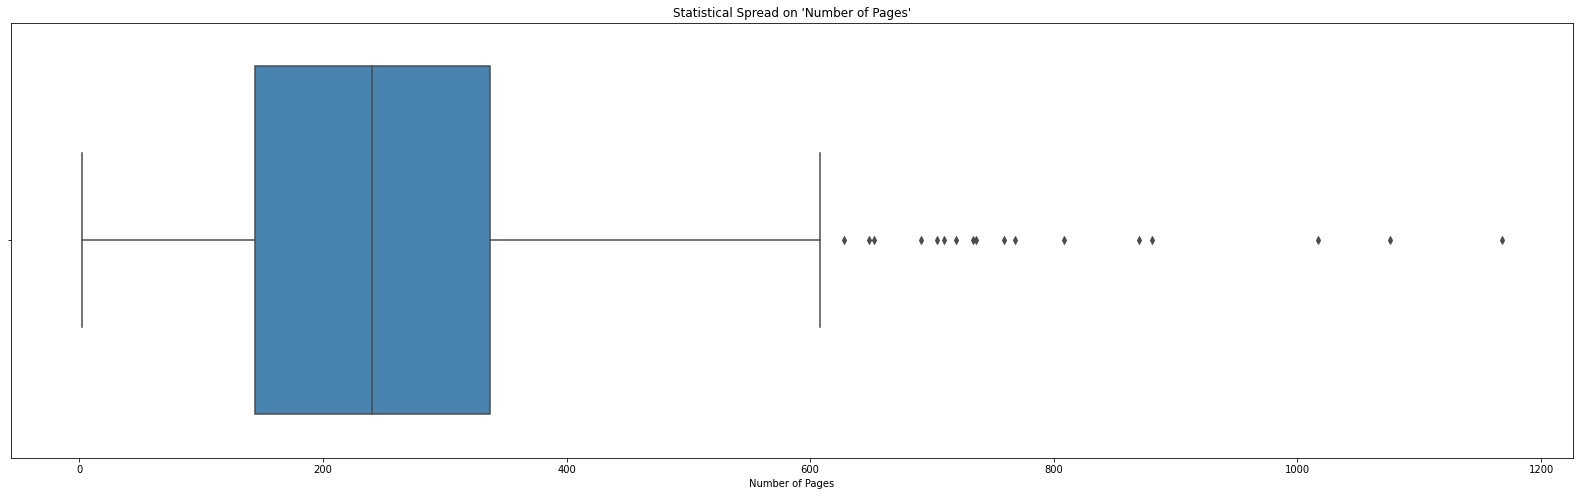

Mean: 264.0
Median: 240.0
Max: 1168.0; Title: ['Guardians of the Galaxy by Brian Michael Bendis Omnibus, Vol. 1']
Min: 2.0; Title: ['A Perfect Time for Pandas (Magic Tree House, #48)']


In [188]:
fig, ax = plt.subplots(figsize=(28,8))
sns.boxplot(x=pages, palette='Blues_d').set_title("Statistical Spread on 'Number of Pages'")
plt.show()

pages_mean = round(raw['Number of Pages'].mean(), 0)
pages_median = round(raw['Number of Pages'].median(), 0)
pages_max = round(raw['Number of Pages'].max(), 0)
book_max = raw.loc[raw['Number of Pages'] == pages_max]
pages_min = round(raw['Number of Pages'].min(), 0)
book_min = raw.loc[raw['Number of Pages'] == pages_min]

print('Mean: {}'.format(pages_mean))
print('Median: {}'.format(pages_median))
print('Max: {}; Title: {}'.format(pages_max, book_max['Title'].values))
print('Min: {}; Title: {}'.format(pages_min, book_min['Title'].values))

### Authors

Checklist:
 - Most Read Authors
 - Most Read Authors by Books Read
 - Most Read Authors by Pages Read
 - Most Read Authors factoring in Read Count

In [189]:
author_read_counts = books_read['Author'].value_counts().rename_axis('Author').reset_index(name='Counts')
author_read_counts = author_read_counts[author_read_counts['Counts'] > 1]
print("The number of authors you have read twice or more: {}".format(author_read_counts['Author'].count()))

The number of authors you have read twice or more: 87


In [190]:
authors = books_read['Author'].value_counts()
authors_dataframe = pd.DataFrame({'Author': authors.index, 'Books Read': authors.values})
authors_top20 = authors_dataframe[:20]
print('Top 20 Most Read Authors')
print('')
authors_top20

Top 20 Most Read Authors



,Author,Books Read
0,"Bendis, Brian Michael",52
1,"Osborne, Mary Pope",50
2,"King, Tom",14
3,"Snyder, Scott",12
4,"Horowitz, Anthony",10
5,"Johns, Geoff",10
6,"Soule, Charles",9
7,"Spencer, Nick",8
8,"Riordan, Rick",8
9,"Rowling, J.K.",8


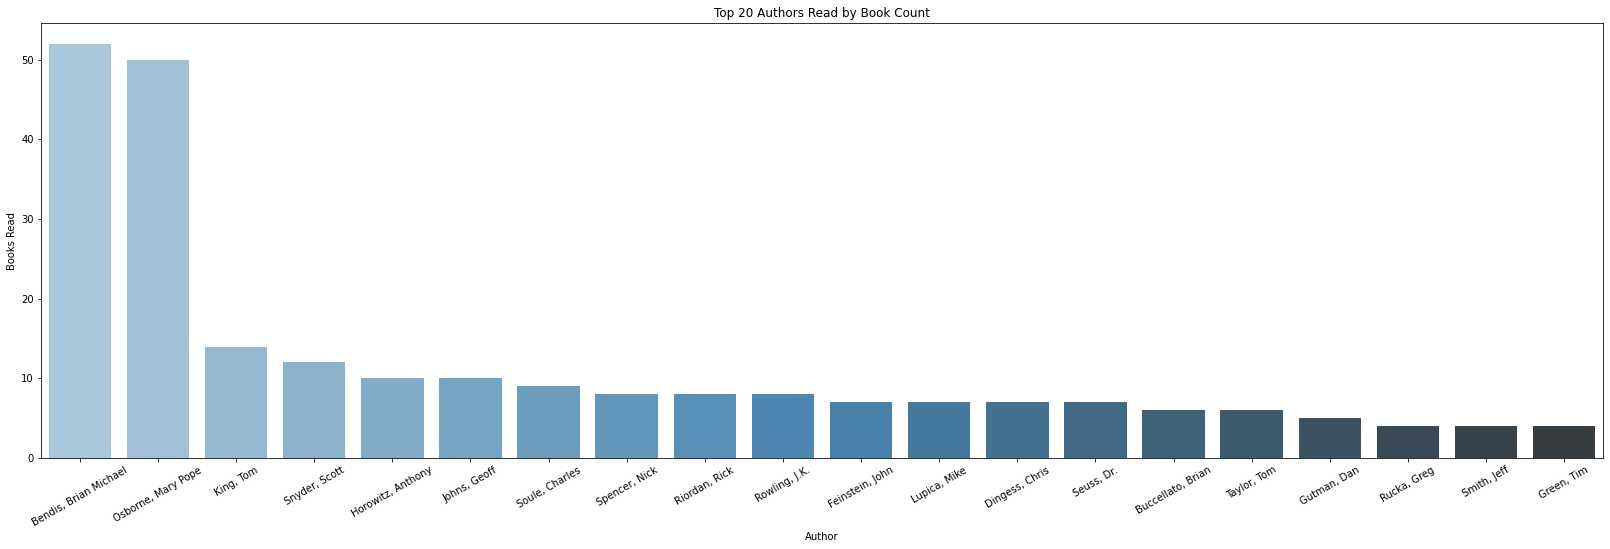

In [191]:
fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=authors_top20['Author'], y=authors_top20['Books Read'], palette='Blues_d')
ax.set_title('Top 20 Authors Read by Book Count')
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

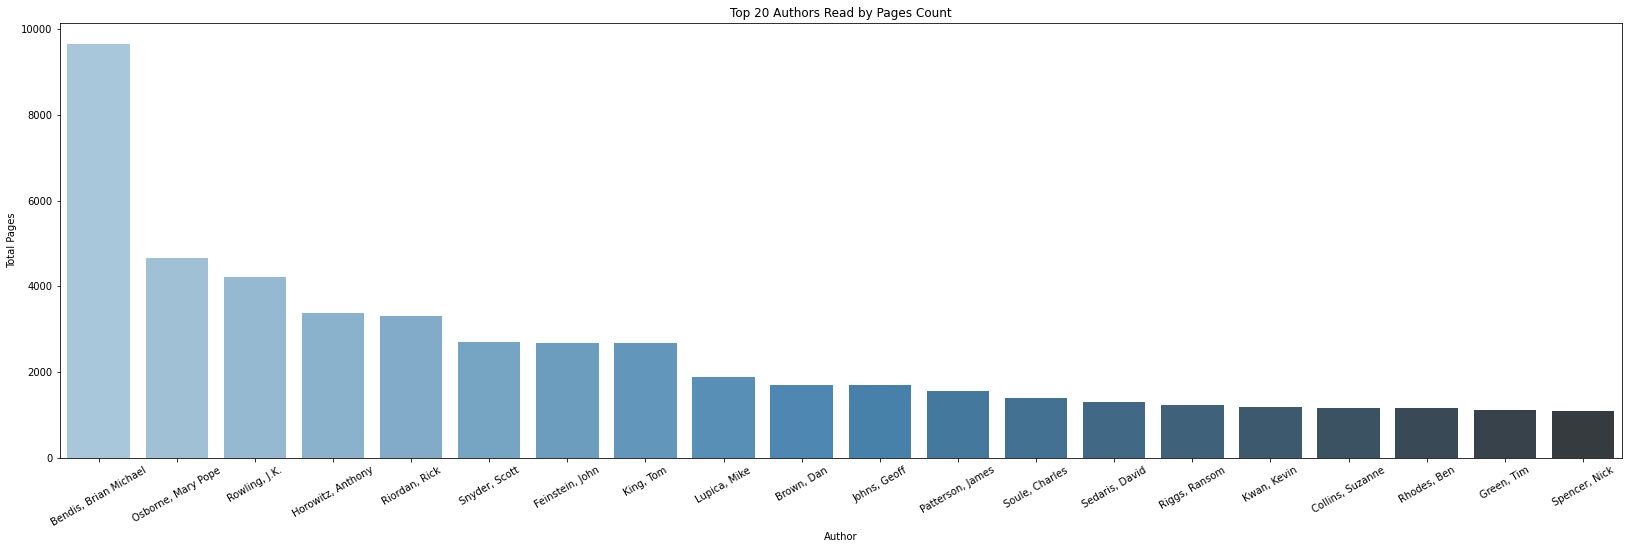

In [192]:
author_groupings = books_read.groupby('Author')
authors_pages = author_groupings['Number of Pages'].sum()
authors_pages_df = pd.DataFrame({'Author': authors_pages.index, 'Total Pages': authors_pages.values})
authors_pages_df_sorted = authors_pages_df.sort_values(by=['Total Pages'], ascending=False)
authors_pages_df_sorted_top20 = authors_pages_df_sorted[:20]

fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=authors_pages_df_sorted_top20['Author'], y=authors_pages_df_sorted_top20['Total Pages'], palette='Blues_d')
ax.set_title('Top 20 Authors Read by Pages Count')
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

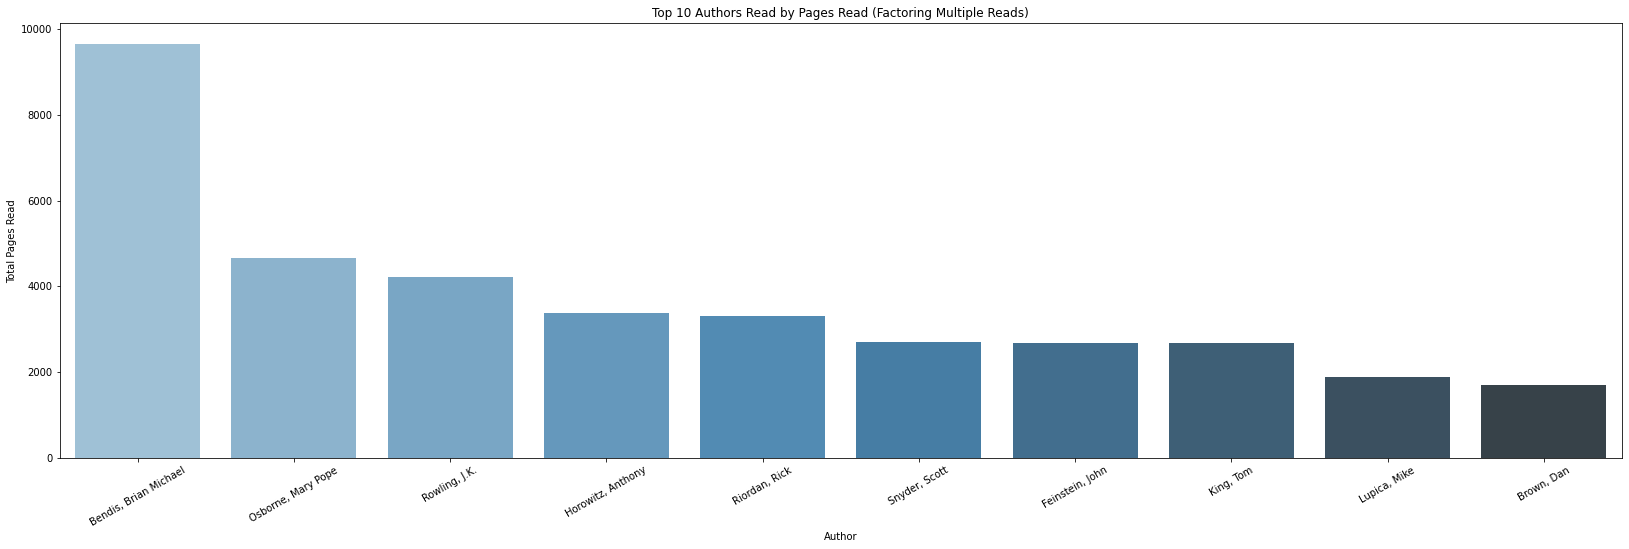

In [193]:
authors_df = books_read[['Title', 'Author', 'Number of Pages', 'Read Count']]
authors_df['Total Pages Read'] = authors_df['Number of Pages'] * authors_df['Read Count']
author_groupings = authors_df.groupby('Author')
author_tps = author_groupings['Total Pages Read'].sum()
author_tps_df = pd.DataFrame({'Author': author_tps.index, 'Total Pages Read': author_tps.values})
author_tps_df_sorted = author_tps_df.sort_values(by='Total Pages Read', ascending=False)
author_tps_df_sorted_top10 = author_tps_df_sorted[:10]

fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=author_tps_df_sorted_top10['Author'], y=author_tps_df_sorted_top10['Total Pages Read'], palette='Blues_d')
ax.set_title('Top 10 Authors Read by Pages Read (Factoring Multiple Reads)')
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

## Ratings Analysis

Checklist
 - Statistical Spread on 'Numbers of Pages'
 - Statistical Spread on 'Numbers of Pages' adjusted for outliers

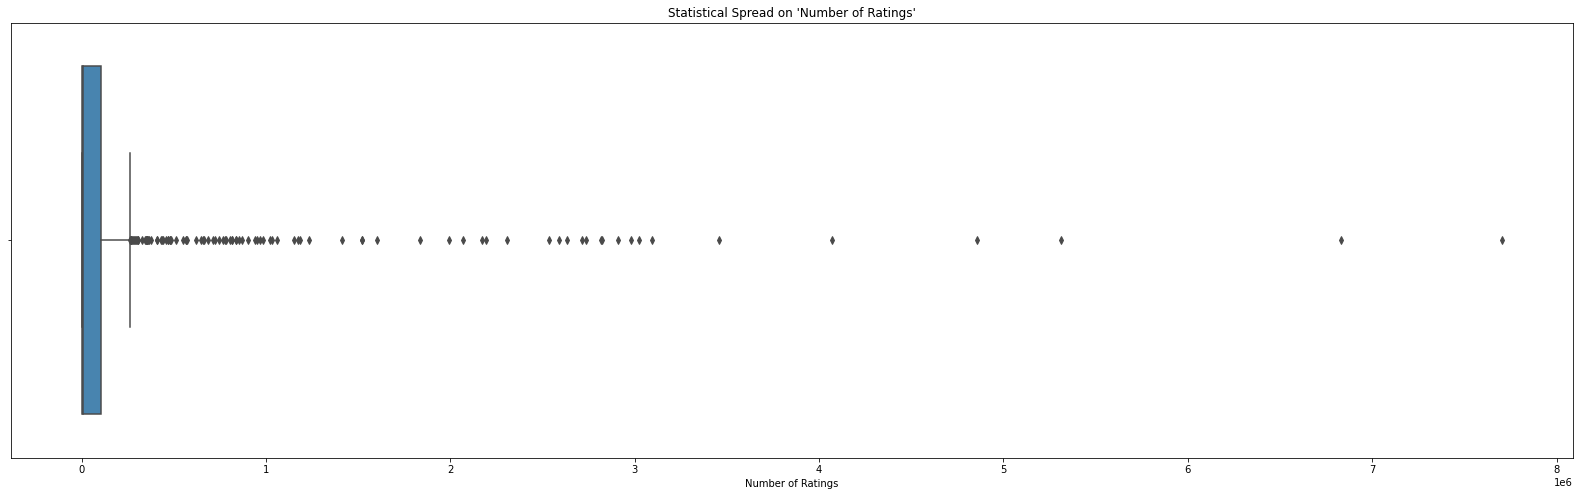

Mean: 231611.0
Median: 7666.0
Max: 7704726; Title: ["Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"]
Min: 1; Title: ['American Made']


In [194]:
fig, ax = plt.subplots(figsize=(28,8))
sns.boxplot(x=books_read['Number of Ratings'], palette='Blues_d').set_title("Statistical Spread on 'Number of Ratings'")
plt.show()

ratings_mean = round(books_read['Number of Ratings'].mean(), 0)
ratings_median = round(books_read['Number of Ratings'].median(), 0)
ratings_max = round(books_read['Number of Ratings'].max(), 0)
book_max = books_read.loc[books_read['Number of Ratings'] == ratings_max]
ratings_min = round(books_read['Number of Ratings'].min(), 0)
book_min = books_read.loc[books_read['Number of Ratings'] == ratings_min]

print('Mean: {}'.format(ratings_mean))
print('Median: {}'.format(ratings_median))
print('Max: {}; Title: {}'.format(ratings_max, book_max['Title'].values))
print('Min: {}; Title: {}'.format(ratings_min, book_min['Title'].values))

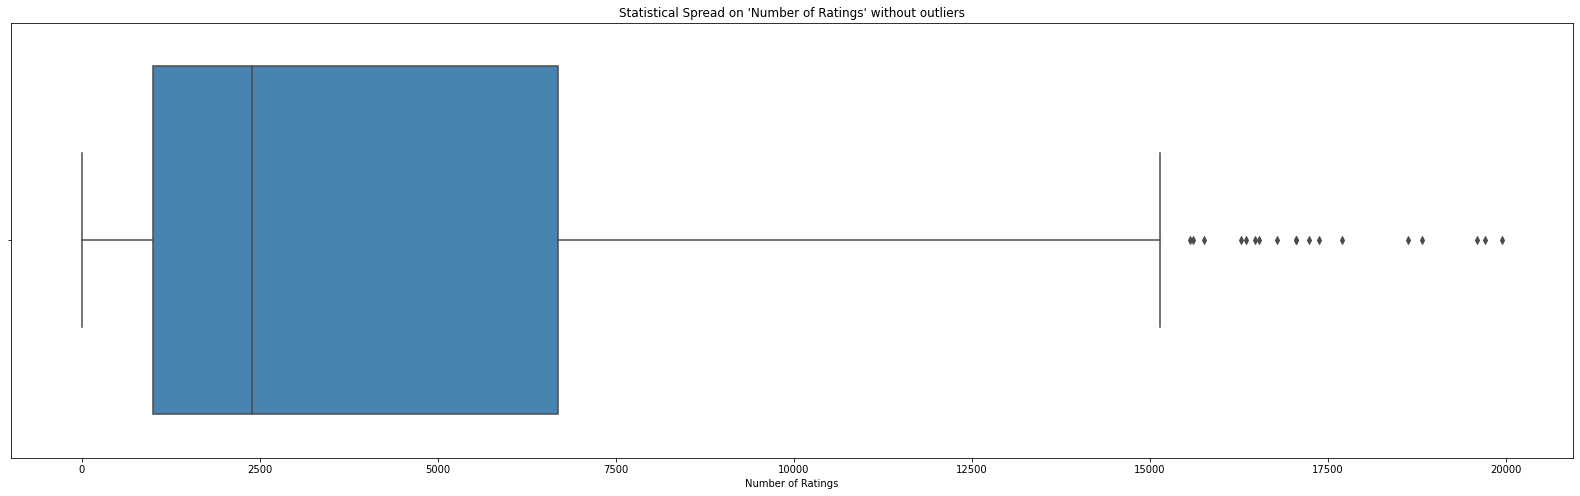

Mean: 4450.0
Median: 2396.0
Max: 19946; Title: ['Mummies in the Morning (Magic Tree House, #3)']
Min: 1; Title: ['American Made']


In [195]:
ratings_no_outliers = books_read[books_read['Number of Ratings'] <= 20000]

fig, ax = plt.subplots(figsize=(28,8))
sns.boxplot(x=ratings_no_outliers['Number of Ratings'], palette='Blues_d').set_title("Statistical Spread on 'Number of Ratings' without outliers")
plt.show()

ratings_mean = round(ratings_no_outliers['Number of Ratings'].mean(), 0)
ratings_median = round(ratings_no_outliers['Number of Ratings'].median(), 0)
ratings_max = round(ratings_no_outliers['Number of Ratings'].max(), 0)
book_max = ratings_no_outliers.loc[ratings_no_outliers['Number of Ratings'] == ratings_max]
ratings_min = round(ratings_no_outliers['Number of Ratings'].min(), 0)
book_min = ratings_no_outliers.loc[ratings_no_outliers['Number of Ratings'] == ratings_min]

print('Mean: {}'.format(ratings_mean))
print('Median: {}'.format(ratings_median))
print('Max: {}; Title: {}'.format(ratings_max, book_max['Title'].values))
print('Min: {}; Title: {}'.format(ratings_min, book_min['Title'].values))

Text(0.5, 1.0, 'Most Rated Books on GoodReads in your Reading History')

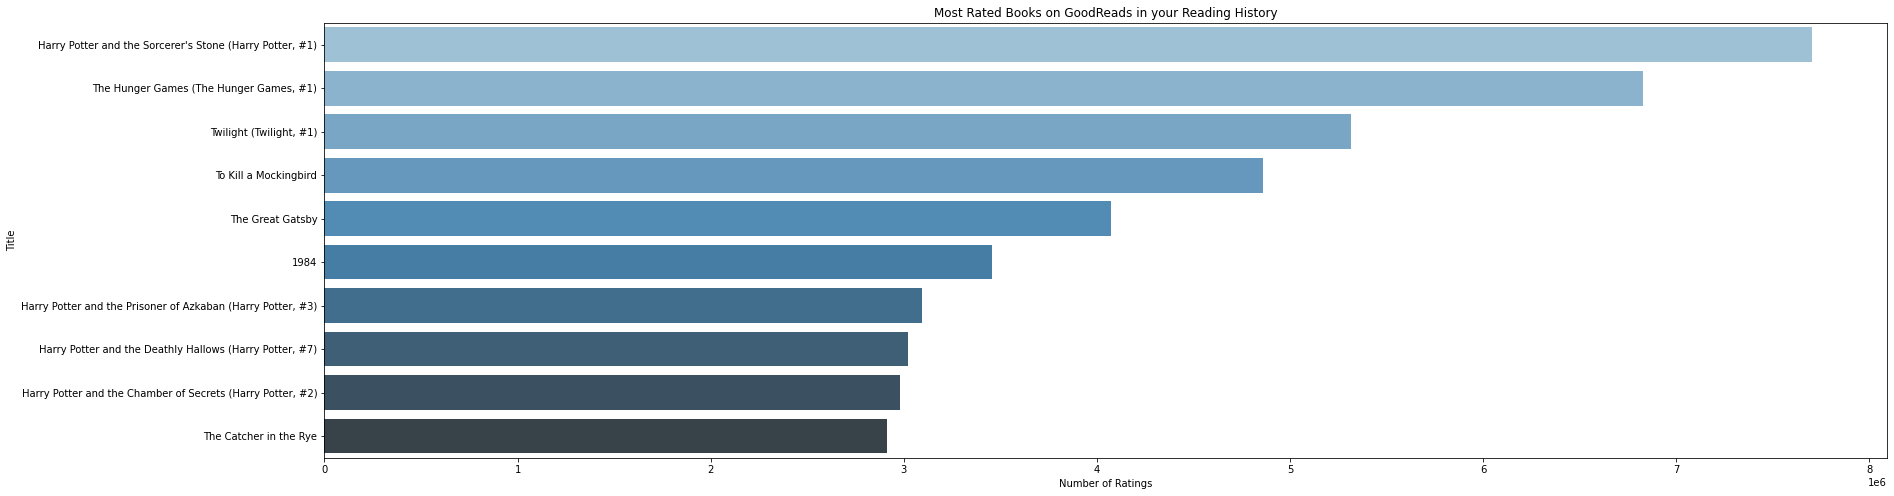

In [196]:
most_rated = books_read.sort_values('Number of Ratings', ascending = False).head(10).set_index('Title')
plt.figure(figsize=(28,8))
sns.barplot(most_rated['Number of Ratings'], most_rated.index, palette='Blues_d').set_title("Most Rated Books on GoodReads in your Reading History")

## Dates & Reading Time

Checklist
 - Longest Reads by Days Spent Reading
 - Books with Most Pages Read per Day
 - Books with Least Pages Read per Day

In [197]:
reading_time_df = books_read[books_read['Reading Time (Days)'].notnull()]

Text(0.5, 1.0, 'Longest Reads by Day Spent Reading')

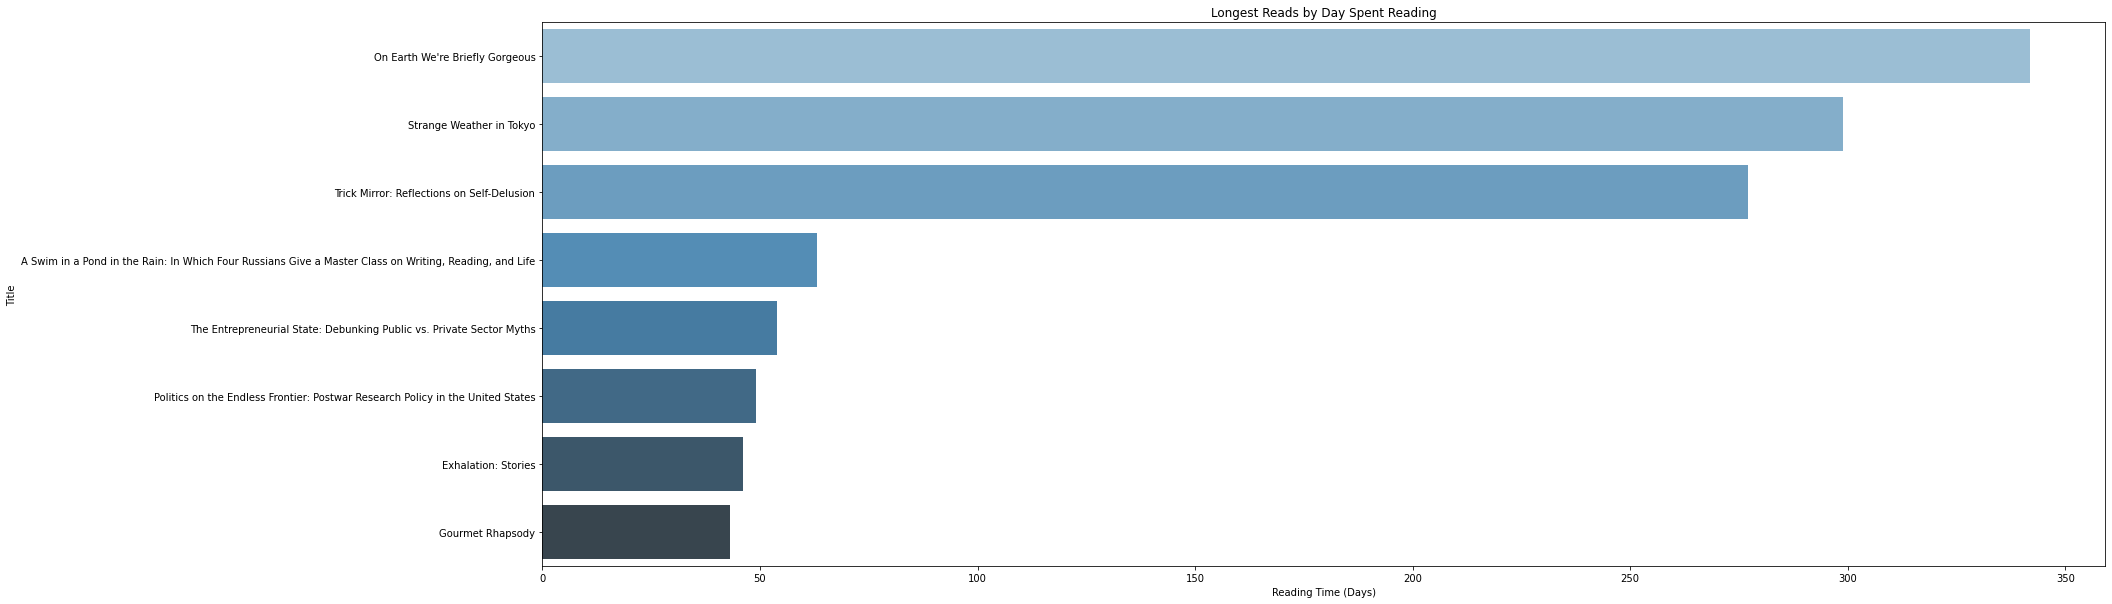

In [198]:
longest_reads = reading_time_df.sort_values(by='Reading Time (Days)', ascending=False).head(10).set_index('Title')
plt.figure(figsize=(28,10))
sns.barplot(longest_reads['Reading Time (Days)'], longest_reads.index, palette='Blues_d').set_title("Longest Reads by Day Spent Reading")

In [199]:
reading_time_df['Pages/Day'] = round(reading_time_df['Number of Pages'] / reading_time_df['Reading Time (Days)'], 2)
reading_time_df['Pages/Day'].replace([np.inf, -np.inf], np.nan, inplace=True)
reading_time_df['Pages/Day'].fillna(reading_time_df['Number of Pages'], inplace=True)

Text(0.5, 1.0, 'Books with Most Pages Read per Day')

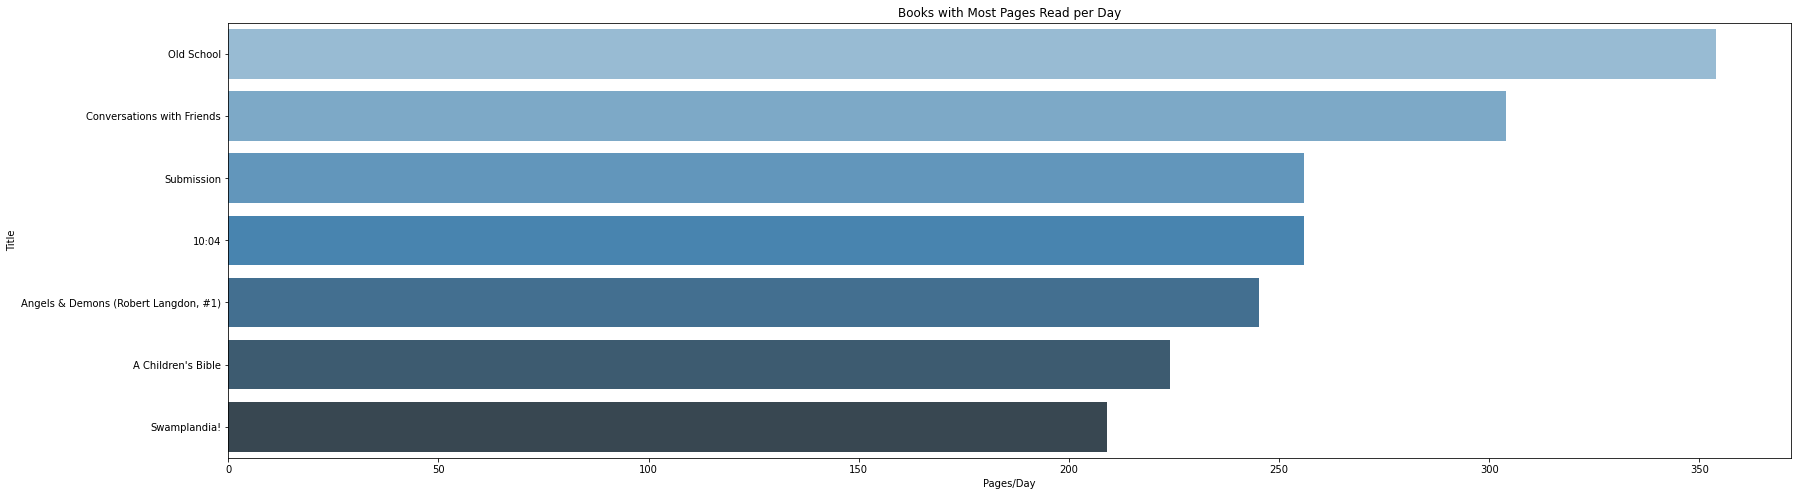

In [200]:
most_pages_read_daily = reading_time_df.sort_values(by='Pages/Day', ascending=False).head(10).set_index('Title')
fig, ax = plt.subplots(figsize=(28,8))
sns.barplot(most_pages_read_daily['Pages/Day'], most_pages_read_daily.index, palette='Blues_d').set_title("Books with Most Pages Read per Day")

Text(0.5, 1.0, 'Books with Least Pages Read per Day')

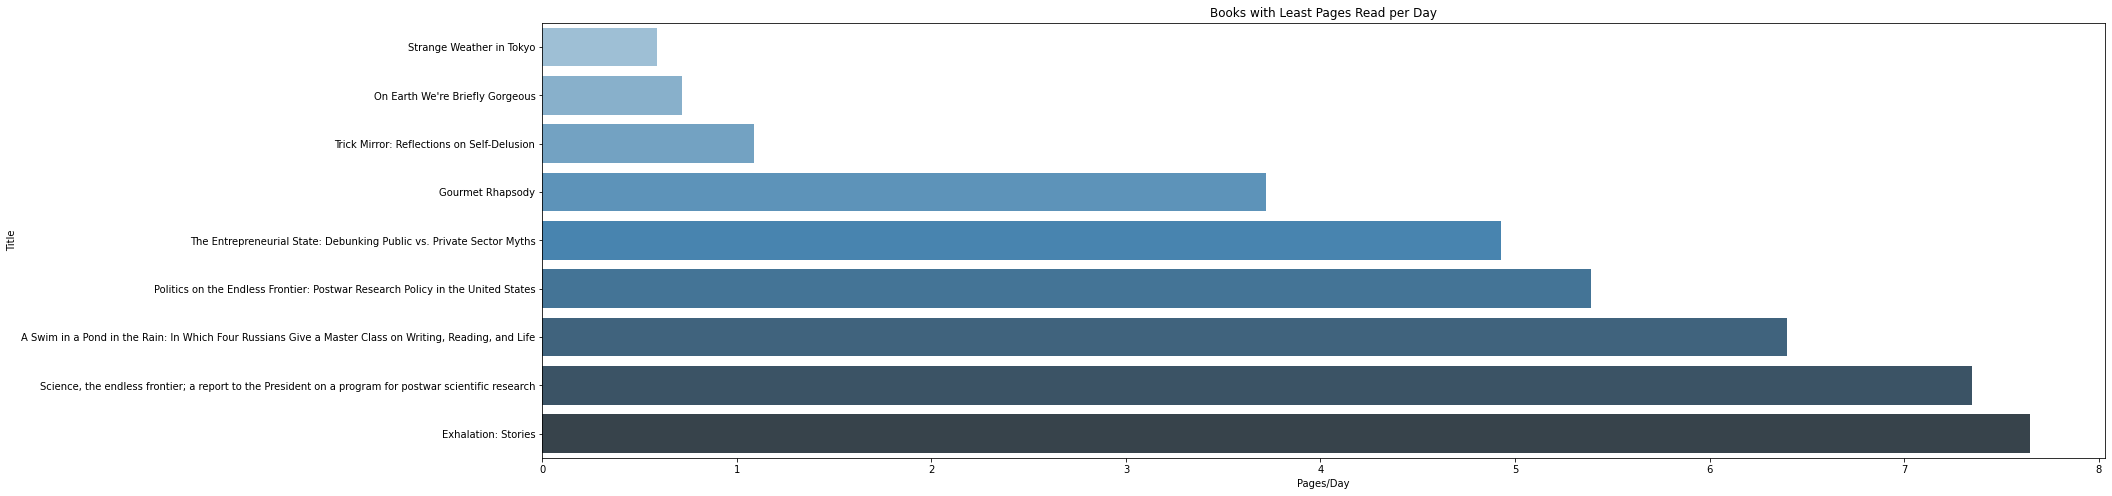

In [201]:
least_pages_read_daily = reading_time_df.sort_values(by='Pages/Day', ascending=True).head(10).set_index('Title')
fig, ax = plt.subplots(figsize=(28,8))
sns.barplot(least_pages_read_daily['Pages/Day'], least_pages_read_daily.index, palette='Blues_d').set_title("Books with Least Pages Read per Day")

# Other Possible Directions

Author Read Counts
- Box Plot distributions for the pages of every individual book of the top 10 most read authors

Author Likability
- Average ratings and Number of Ratings
- Deviation from average rating based on my ratings
- Scatterplot of Avg. Rating v Number of Ratings